In [9]:
cd /content/drive/Mydrive/

/content/drive


In [12]:
!pip install japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 3.5 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=c956a34c7729e58883f8aca2c7054781627d263d75ffb32b210d26e40fe417bb
  Stored in directory: /root/.cache/pip/wheels/4f/ca/96/4cc5e192421cceb077fbf4ffec533382edd416fd3fa0af0bbd
Successfully built japanize-matplotlib


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
sns.set()

from datetime import date
import holidays
import datetime as dt
import japanize_matplotlib

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
df = pd.read_csv("/content/drive/MyDrive/LSTMの実装：引越し需要予測/train.csv")
df.head()

,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17,0,0,-1,-1
1,2010-07-02,18,0,0,-1,-1
2,2010-07-03,20,0,0,-1,-1
3,2010-07-04,20,0,0,-1,-1
4,2010-07-05,14,0,0,-1,-1


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datetime  2101 non-null   object
 1   y         2101 non-null   int64 
 2   client    2101 non-null   int64 
 3   close     2101 non-null   int64 
 4   price_am  2101 non-null   int64 
 5   price_pm  2101 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 98.6+ KB


In [17]:
# 0	datetime	日時（YYYY-MM-DD）	文字列
# 1	y	引越し数	数値：整数
# 2	client	法人が絡む特殊な引越し日フラグ	数値：整数（0,1）
# 3	close	休業日	数値：整数（0,1）
# 4	price_am	午前の料金区分（-1は欠損を表す。5が最も料金が高い）	数値：整数（-1,0,1,2,3,4,5）
# 5	price_pm	午後の料金区分（-1は欠損を表す。5が最も料金が高い）	数値：整数（-1,0,1,2,3,4,5）

In [18]:
np.arange(0,len(df))

array([   0,    1,    2, ..., 2098, 2099, 2100])

##　内井入力

In [19]:
from datetime import date
import holidays
holidays_d = []
for i in np.arange(0,len(df)):
    a= df["datetime"][i] in holidays.JP()
    holidays_d.append(a)
df["holidays"] = holidays_d
df = df.replace({False:0, True:1})

##　以下　寺澤さん入力

In [20]:
#datetimeを日付型に変換
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d')

## testファイルは2016年度のもの

In [21]:
df_test = pd.read_csv("/Users/uchiiyusaku/Documents/dataset/引越しデータ/train.csv")
df_test

FileNotFoundError: ignored

2016年の引っ越し需要予測を予測精度とする

# データの理解

In [22]:
df['datetime'].dt.year.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016])

In [23]:
df.head()

,datetime,y,client,close,price_am,price_pm,holidays
0,2010-07-01,17,0,0,-1,-1,0
1,2010-07-02,18,0,0,-1,-1,0
2,2010-07-03,20,0,0,-1,-1,0
3,2010-07-04,20,0,0,-1,-1,0
4,2010-07-05,14,0,0,-1,-1,0


In [24]:
df.tail()

,datetime,y,client,close,price_am,price_pm,holidays
2096,2016-03-27,94,1,0,5,4,0
2097,2016-03-28,86,1,0,4,4,0
2098,2016-03-29,98,1,0,4,4,0
2099,2016-03-30,99,1,0,5,4,0
2100,2016-03-31,105,1,0,5,4,0


trainデータは2010年7月1日～2016年3月31日のデータ。\
そこから2016年4月1日からの一年間の需要を予測する。

## 年月日曜日列を作成

In [25]:
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['Weekday'] = df['datetime'].dt.strftime('%A')

In [26]:
df

,datetime,y,client,close,price_am,price_pm,holidays,year,month,day,Weekday
0,2010-07-01,17,0,0,-1,-1,0,2010,7,1,Thursday
1,2010-07-02,18,0,0,-1,-1,0,2010,7,2,Friday
2,2010-07-03,20,0,0,-1,-1,0,2010,7,3,Saturday
3,2010-07-04,20,0,0,-1,-1,0,2010,7,4,Sunday
4,2010-07-05,14,0,0,-1,-1,0,2010,7,5,Monday
...,...,...,...,...,...,...,...,...,...,...,...
2096,2016-03-27,94,1,0,5,4,0,2016,3,27,Sunday
2097,2016-03-28,86,1,0,4,4,0,2016,3,28,Monday
2098,2016-03-29,98,1,0,4,4,0,2016,3,29,Tuesday
2099,2016-03-30,99,1,0,5,4,0,2016,3,30,Wednesday


In [27]:
#2011年4月1日から一年分を取り出していろいろやってみる
##2010年のデータは7月から始まっているため除外したい　→　7月から翌年3月末までのデータに特異な点がないか後に確認する
df_2011 = df[(df['datetime'] > dt.datetime(2011,3,31)) & (df['datetime'] < dt.datetime(2012,3,31))]
df_2012 = df[(df['datetime'] > dt.datetime(2012,3,31)) & (df['datetime'] < dt.datetime(2013,3,31))]
df_2013 = df[(df['datetime'] > dt.datetime(2013,3,31)) & (df['datetime'] < dt.datetime(2014,3,31))]
df_2014 = df[(df['datetime'] > dt.datetime(2014,3,31)) & (df['datetime'] < dt.datetime(2015,3,31))]
df_2015 = df[(df['datetime'] > dt.datetime(2015,3,31)) & (df['datetime'] < dt.datetime(2016,3,31))]

### 月単位でyを可視化

In [28]:
# plt.plot(df_2011.groupby('month').sum()['y'], marker='*', c='red', label='2011')
# plt.plot(df_2012.groupby('month').sum()['y'], marker='o', c='green', label='2012')
# plt.plot(df_2013.groupby('month').sum()['y'], marker='v', c='black', label='2013')
# plt.plot(df_2014.groupby('month').sum()['y'], marker='D', c='blue', label='2014')
# plt.plot(df_2015.groupby('month').sum()['y'], marker='*', c='orange', label='2015')

# plt.title()
# plt.legend()
# plt.show()

2011年度はやはり引っ越し数は落ち込んでいる。\
以降は年々回復傾向にあることが読み取れる

### 曜日別でyを可視化

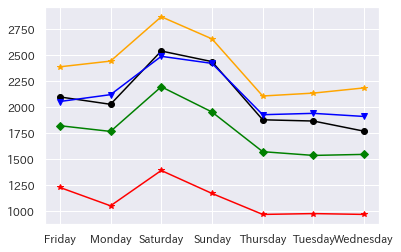

In [29]:
plt.plot(df_2011.groupby('Weekday').sum()['y'], marker='*', c='red')
plt.plot(df_2012.groupby('Weekday').sum()['y'], marker='D', c='green')
plt.plot(df_2013.groupby('Weekday').sum()['y'], marker='o', c='black')
plt.plot(df_2014.groupby('Weekday').sum()['y'], marker='v', c='blue')
plt.plot(df_2015.groupby('Weekday').sum()['y'], marker='*', c='orange')

## やりたいこと：コレログラム、自己相関、変数同士の相関

In [30]:
df.groupby('year')['client'].sum().reset_index()

,year,client
0,2010,0
1,2011,0
2,2012,0
3,2013,0
4,2014,38
5,2015,120
6,2016,48


In [31]:
df_2011.query('(price_am==-1) or (price_pm==-1)')

,datetime,y,client,close,price_am,price_pm,holidays,year,month,day,Weekday
365,2011-07-01,16,0,0,-1,-1,0,2011,7,1,Friday
459,2011-10-03,20,0,0,1,-1,0,2011,10,3,Monday
548,2011-12-31,0,0,1,-1,-1,0,2011,12,31,Saturday
549,2012-01-01,0,0,1,-1,-1,1,2012,1,1,Sunday
550,2012-01-02,0,0,1,-1,-1,1,2012,1,2,Monday
551,2012-01-03,0,0,1,-1,-1,0,2012,1,3,Tuesday


In [32]:
df.query('close==1')

,datetime,y,client,close,price_am,price_pm,holidays,year,month,day,Weekday
183,2010-12-31,0,0,1,-1,-1,0,2010,12,31,Friday
184,2011-01-01,0,0,1,-1,-1,1,2011,1,1,Saturday
185,2011-01-02,0,0,1,-1,-1,0,2011,1,2,Sunday
186,2011-01-03,0,0,1,-1,-1,0,2011,1,3,Monday
548,2011-12-31,0,0,1,-1,-1,0,2011,12,31,Saturday
549,2012-01-01,0,0,1,-1,-1,1,2012,1,1,Sunday
550,2012-01-02,0,0,1,-1,-1,1,2012,1,2,Monday
551,2012-01-03,0,0,1,-1,-1,0,2012,1,3,Tuesday
914,2012-12-31,0,0,1,-1,-1,0,2012,12,31,Monday
915,2013-01-01,0,0,1,-1,-1,1,2013,1,1,Tuesday


祝日平日フラグの列を加える。フラグによってprice_am,price_pmの値に変動があるか確認する。
\データフレームはcsv方式でgitへyyyymmddでファイル名とし、divelopmentへpush

## 以下内井作成

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  2101 non-null   datetime64[ns]
 1   y         2101 non-null   int64         
 2   client    2101 non-null   int64         
 3   close     2101 non-null   int64         
 4   price_am  2101 non-null   int64         
 5   price_pm  2101 non-null   int64         
 6   holidays  2101 non-null   int64         
 7   year      2101 non-null   int64         
 8   month     2101 non-null   int64         
 9   day       2101 non-null   int64         
 10  Weekday   2101 non-null   object        
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 180.7+ KB


In [34]:
df.head()

,datetime,y,client,close,price_am,price_pm,holidays,year,month,day,Weekday
0,2010-07-01,17,0,0,-1,-1,0,2010,7,1,Thursday
1,2010-07-02,18,0,0,-1,-1,0,2010,7,2,Friday
2,2010-07-03,20,0,0,-1,-1,0,2010,7,3,Saturday
3,2010-07-04,20,0,0,-1,-1,0,2010,7,4,Sunday
4,2010-07-05,14,0,0,-1,-1,0,2010,7,5,Monday


In [35]:
df_day_off= df.query('Weekday == "Saturday" | Weekday == "Sunday" | holidays==1')
#休日か祝日のデータを抽出


In [36]:
df_day_off.groupby(["year", "month" ,"Weekday"])["y"].sum()

year  month  Weekday 
2010  7      Monday       18
             Saturday    105
             Sunday       78
      8      Saturday     82
             Sunday       93
                        ... 
2016  2      Sunday      240
             Thursday     42
      3      Monday      100
             Saturday    338
             Sunday      331
Name: y, Length: 213, dtype: int64

Text(0.5, 1.0, '引越しの件数')

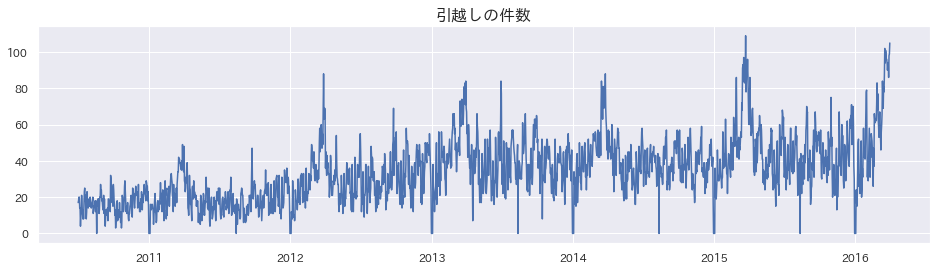

In [39]:
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(df['datetime'], df['y'])
ax.set_title("引越しの件数",fontsize=16)

In [82]:
data = df[["datetime","y"]]
len(data)

2101

## モデル実装

In [88]:
!pip3 install keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 学習データの作成

In [ ]:
# 2011年４月１日から２０１５年３月３１日までのデータを訓練用データとする
train_data = data[data["datetime"] >= "2011-04-01" ]
train_data = train_data[ train_data["datetime"] <="2015-03-31"]

train_data = train_data["y"].values

# 2015年４月１日から２０１６年３月３１日までの期間をテストデータとする

test_data = data[data["datetime"] >= "2015-04-01"]
test_data = test_data["y"].values

In [160]:
#学習データの作成
# f:ノイズが加わったサインの値

def make_dataset(low_data):
  data , target = [],[]
  max_len = 30 #data件数の数

  for i  in range (len(low_data)-max_len): #データの件数から箱の数を引いている
    data.append(low_data[i: i+max_len])  # 最初０:0+25とすることで、0から24までの25件のデータを取得している。次の繰り返しは最初の0の値を除いた1から26のインデックス番号を取得
    target.append(low_data[i + max_len]) #最初0から24までのデータを用いて25番の値をターゲットとしている。

  re_data = np.array(data).reshape(len(data),max_len,1) #データの箱の数、中に入っているデータ件数、１というように３次元にしている。
  re_target = np.array(target).reshape(len(data), 1)#データの数@1　の２次元にしている。

  return re_data ,re_target


g , h = make_dataset(train_data)

In [161]:
#　次元数の確認
print("トレーニングデータの次元数",g.shape)
print("トレーニングデータの正解データ件数",h.shape)

トレーニングデータの次元数 (1431, 30, 1)
トレーニングデータの正解データ件数 (1431, 1)


## モデル構築

In [153]:
#　モデル構築

# 1つの学習データのStep数（今回は30）

lengh_of_sequence = g.shape[1] 
in_out_nerons = 1
n_hidden = 50 #隠れ層のユニット数（数が多いほど学習モデルの複雑さが増加）
loss = tf.keras.losses.MeanSquaredError() # 最小二乗誤差

model = Sequential()
model.add(LSTM(n_hidden,
               batch_input_shape=(None,lengh_of_sequence , in_out_nerons) ,  #入力データの次元数
               return_sequences=False)) # バッチ型で学習するならここはFalse

model.add = (Dense(in_out_nerons)) # 30のデータから１つの値を予測したいので１となる
model.add = (Activation("linear")) # 活性化関数を指示

# compileで誤差関数：最小二乗誤差、最適化手法：Adamを用いるように定義
optimizer = Adam(lr=0.01)
model.compile(loss=loss , optimizer=optimizer)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [159]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
model.fit(g, h,
          batch_size=100,
          epochs=100, #繰り返し回数
          validation_split=0.1,
          callbacks=[early_stopping])

Epoch 1/100
13/13 [==============================] - 0s 29ms/step - loss: 1267.4626 - val_loss: 2325.3286
Epoch 2/100
13/13 [==============================] - 0s 27ms/step - loss: 1267.4626 - val_loss: 2325.3286
Epoch 3/100
13/13 [==============================] - 0s 26ms/step - loss: 1267.4626 - val_loss: 2325.3286
Epoch 4/100
13/13 [==============================] - 0s 28ms/step - loss: 1267.4626 - val_loss: 2325.3286
Epoch 5/100
13/13 [==============================] - 0s 28ms/step - loss: 1267.4626 - val_loss: 2325.3286
Epoch 6/100
13/13 [==============================] - 0s 29ms/step - loss: 1267.4625 - val_loss: 2325.3286
Epoch 7/100
13/13 [==============================] - 0s 26ms/step - loss: 1267.4626 - val_loss: 2325.3286
Epoch 8/100
 1/13 [=>............................] - ETA: 0s - loss: 1528.0624

KeyboardInterrupt: ignored

In [136]:
# 予測
predicted = model.predict(g)
predicted
predicted.shape
predicted[:,4]

45/45 [==============================] - 0s 7ms/step


array([0.9999983, 0.9999971, 0.9999983, ..., 1.       , 1.       ,
       1.       ], dtype=float32)

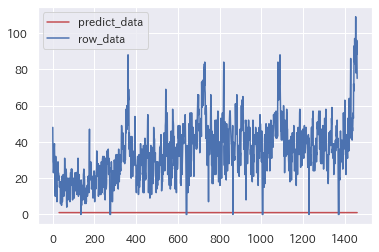

In [139]:
plt.figure()
plt.plot(range(30,len(predicted)+30),predicted[: ,4], color="r", label="predict_data")
plt.plot(range(0, len(train_data["y"].values)), train_data["y"].values, color="b", label="row_data")
plt.legend()
plt.show()